Autoencoders
======

In [1]:
# # install pytorch (http://pytorch.org/) if run from Google Colaboratory
! pip install torchvision
import sys
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

  Using cached torchvision-0.21.0-cp39-cp39-macosx_11_0_arm64.whl (1.8 MB)
  Using cached torch-2.6.0-cp39-none-macosx_11_0_arm64.whl (66.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1
You should consider upgrading via the '/Users/yuwang/recsys/bin/python3 -m pip install --upgrade pip' command.


Parameter Settings
-------------------

In [2]:
latent_dims = 10
num_epochs = 50
batch_size = 128
capacity = 64
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),  # converts to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # normalize tensor with mean=0.5 and std=0.5. x = (x-0.5)/0.5
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 9.72MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.03MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.12MB/s]


Build Autoencoder
--------
An autoencoder consists of one encoder and one decoder. The encoder encodes the input data into a low-dimensional code/feature vector and the decoder reconstructs the input data from the low-dimensional code.

In [4]:
class MLP_AE(nn.Module):
  def __init__(self,architecture=[784,128,64,2],activation='LeakyReLU'):
        super(MLP_AE, self).__init__()
        self.architecture=architecture
        if activation=='LeakyReLU':
            self.activation=nn.LeakyReLU()
        elif activation=='ReLU':
            self.activation=nn.ReLU()
        elif activation=='Sigmoid':
            self.activation=nn.Sigmoid()
        else:
            print('Activation not defined, reverting to default!')
            self.activation=nn.LeakyReLU()
        # Defining $\phi$
        arch=[]
        for i in range(1,len(architecture)):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            if i!=len(architecture)-1:
                arch.append(self.activation)
        self.encoder=nn.Sequential(*arch)
        # Defining $\psi$
        arch=[]
        for i in range(len(architecture)-1,0,-1):
            arch.append(nn.Linear(architecture[i],architecture[i-1]))
            if i!=1:
                arch.append(self.activation)
        self.decoder=nn.Sequential(*arch)

  def encode(self,f):
        assert f.shape[1]==self.architecture[0]
        return self.encoder(f)

  def decode(self,fhat):
        assert fhat.shape[1]==self.architecture[-1]
        return self.decoder(fhat)

  def forward(self,x):
    return self.decode(self.encode(x))
    
autoencoder = MLP_AE()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 218514


Train Autoencoder
--------

In [5]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

# MSE loss is used to compute the reconstruction error.
criterion=nn.MSELoss()

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        # flatten image into 1-D vector
        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = criterion(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.243305
Epoch [2 / 50] average reconstruction error: 0.192414
Epoch [3 / 50] average reconstruction error: 0.179662
Epoch [4 / 50] average reconstruction error: 0.173982
Epoch [5 / 50] average reconstruction error: 0.170547
Epoch [6 / 50] average reconstruction error: 0.168231
Epoch [7 / 50] average reconstruction error: 0.166086
Epoch [8 / 50] average reconstruction error: 0.164264
Epoch [9 / 50] average reconstruction error: 0.162902
Epoch [10 / 50] average reconstruction error: 0.161284
Epoch [11 / 50] average reconstruction error: 0.160438
Epoch [12 / 50] average reconstruction error: 0.159475
Epoch [13 / 50] average reconstruction error: 0.158693
Epoch [14 / 50] average reconstruction error: 0.157955
Epoch [15 / 50] average reconstruction error: 0.157595
Epoch [16 / 50] average reconstruction error: 0.157109
Epoch [17 / 50] average reconstruction error: 0.156423
Epoch [18 / 50] average reconstruction error: 0.155957
Epoch 

Plot Training Curve
--------------------

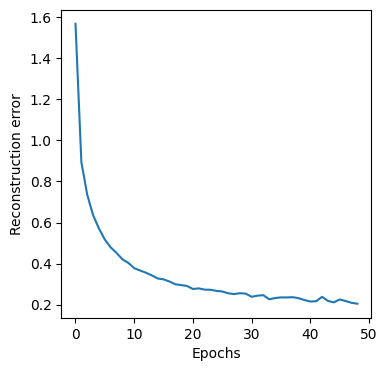

In [29]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize = (4, 4))
plt.plot(train_loss_avg[:-1])
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.savefig('loss.png')

Evaluate on the Test Set
-------------------------

In [7]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    # gradient calculation is disabled for inference
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)

        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.148530


Visualize Reconstructions
--------------------------

Original images


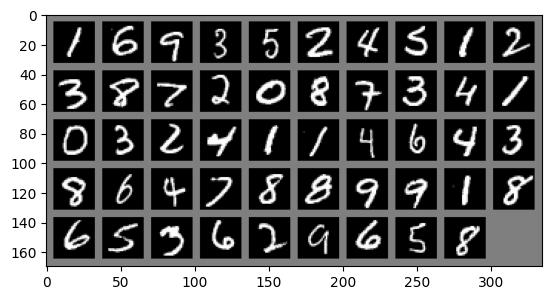

Autoencoder reconstruction:
torch.Size([128, 1, 28, 28])


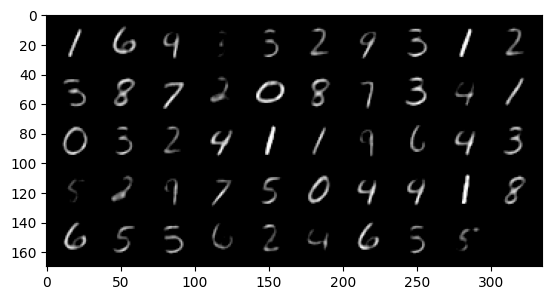

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# Note that when we preprocess the data by converting them to 
# the range of [0, 1] and then normalize and center them around 0. 
# After normalization, x was in the range of [-1, 1]. 
# to_img function can convert the x back to its original range of [0, 1].
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy() # convert torch.tensor to numpy.array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# This function takes an image to reconstruct as an input
# and the name of the model with which the reconstructions
# are performed
def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images.reshape(images.shape[0],-1))
        images = images.reshape(images.shape[0],1,28,28).cpu()
        images = images.clamp(0,1)
        print(images.shape)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))


# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

Visualize low-dimensional latent feature
-------------------------
In this section, we use our trained encoder to encode each input data into a low-dimensional 2D feature vector. Then we visualize the 2D feature in a plane along with its label. Different colors correspond different numbers.

In [10]:
Z=[]  # latent features
labels=[] 
for image_batch, label in test_dataloader:    
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        Z.append(autoencoder.encode(image_batch).data.cpu().numpy())
        labels.append(label.data.cpu().numpy())

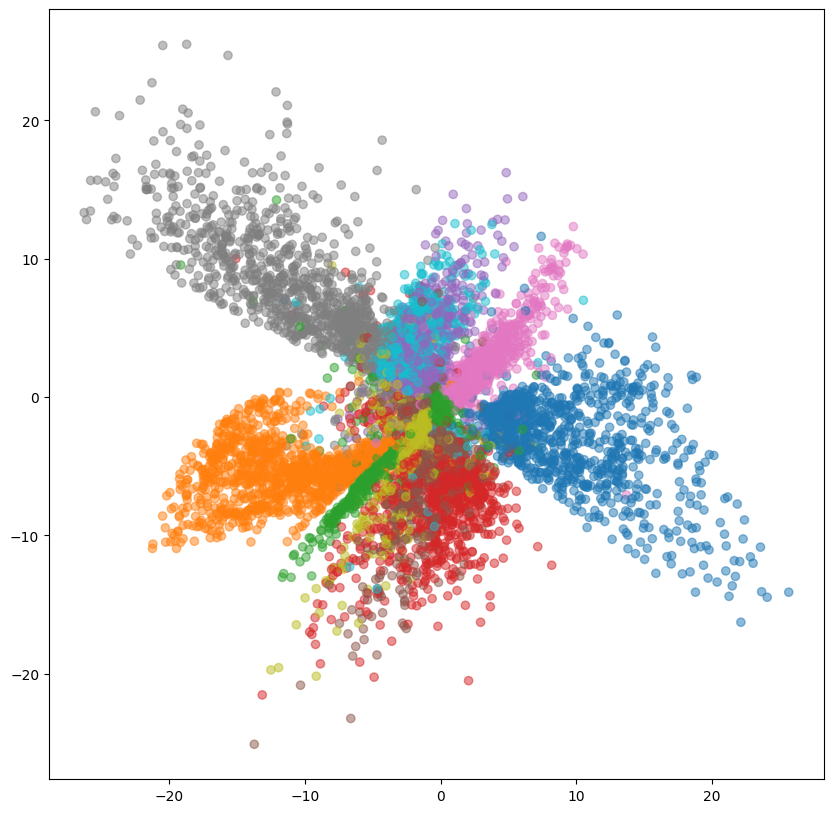

In [11]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.5,
            c=np.concatenate(labels),cmap='tab10')

Visualize images from latent features
-------------------------
In the previous section, we visualize all the low-dimensional features in 2D plane. Here, we first define a region in latent space, e.g., a squared region with x and y ranges from -15 to 10. Then, we sample latent features within this region and visualize the corresponding reconstructed images by using decoder.

In [12]:
L=15
X,Y=torch.meshgrid(torch.linspace(-15,10,L),torch.linspace(-15,10,L))
zgrid=torch.stack([X.reshape(-1),Y.reshape(-1)],1)
print(zgrid.shape)

torch.Size([225, 2])


/Users/yuwang/recsys/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


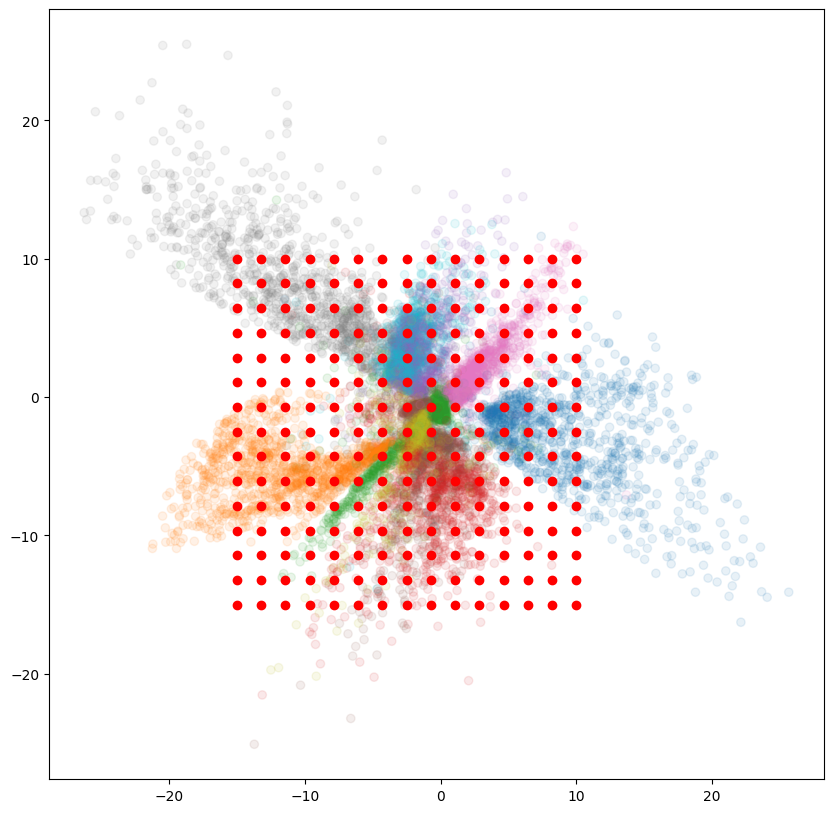

In [13]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.1,
            c=np.concatenate(labels),cmap='tab10')
plt.scatter(zgrid[:,0],zgrid[:,1],c='r')

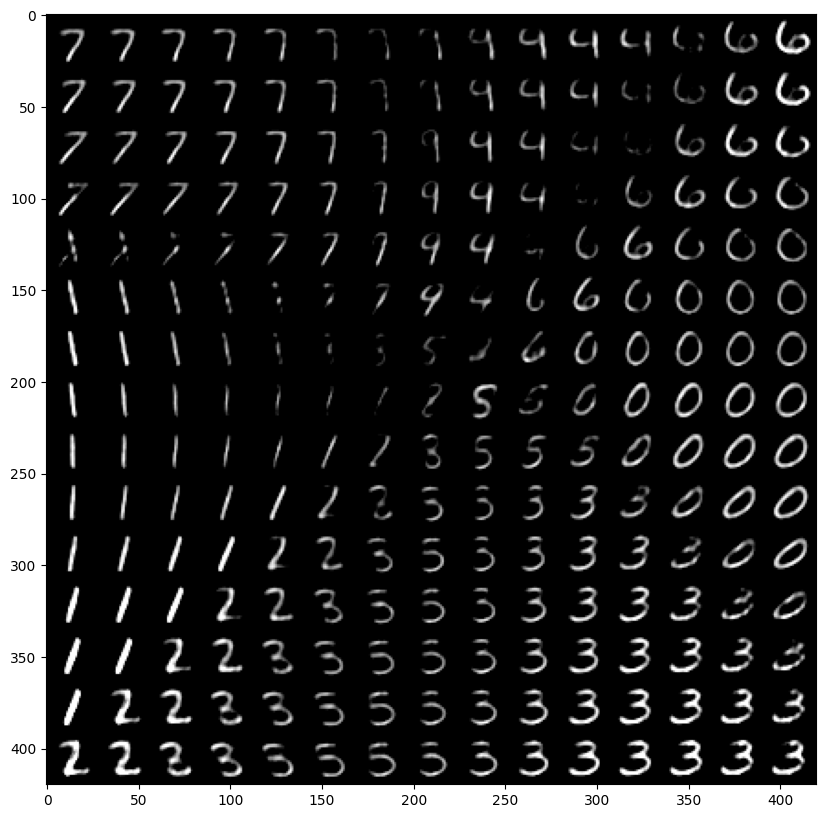

In [14]:
image=autoencoder.decode(zgrid.to(device)).reshape(L**2,28,28).data.clip(0,1).cpu().numpy()
img=np.zeros((L*28,L*28))
count=0
for i in np.arange(L-1,-1,-1):
  for j in np.arange(L-1,-1,-1):    
    img[j*28:(j+1)*28,i*28:(i+1)*28]=image[count,:,::-1]
    count+=1
fig=plt.figure(figsize=(10,10))
img=img[:,::-1]
plt.imshow(img,cmap='gray')

In [15]:
class MLP_Discriminant_AE(nn.Module):
  def __init__(self,architecture=[784,128,64,2],nclasses=10,activation='LeakyReLU'):
        super(MLP_Discriminant_AE, self).__init__()
        self.architecture=architecture
        if activation=='LeakyReLU':
            self.activation=nn.LeakyReLU()
        elif activation=='ReLU':
            self.activation=nn.ReLU()
        elif activation=='Sigmoid':
            self.activation=nn.Sigmoid()
        else:
            print('Activation not defined, reverting to default!')
            self.activation=nn.LeakyReLU()
        # Defining $\phi$
        arch=[]
        for i in range(1,len(architecture)):
            arch.append(nn.Linear(architecture[i-1],architecture[i]))
            if i!=len(architecture)-1:
                arch.append(self.activation)
        self.encoder=nn.Sequential(*arch)
        # Defining $\psi$
        arch=[]
        for i in range(len(architecture)-1,0,-1):
            arch.append(nn.Linear(architecture[i],architecture[i-1]))
            if i!=1:
                arch.append(self.activation)
        self.decoder=nn.Sequential(*arch)
        self.classifier=nn.Linear(architecture[-1],nclasses)
        self.nclasses=nclasses

  def encode(self,f):
        assert f.shape[1]==self.architecture[0]
        return self.encoder(f)

  def decode(self,fhat):
        assert fhat.shape[1]==self.architecture[-1]
        return self.decoder(fhat)

  def forward(self,x):
    z=self.encode(x)
    return self.decode(z),self.classifier(z)
    
model = MLP_Discriminant_AE()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 218544


In [16]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()
train_loss_avg = []
reconCriterion=nn.MSELoss()  # MSE loss is used for image reconstruction
classificationCriterion=nn.CrossEntropyLoss() # CEloss is used for classification
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, y in train_dataloader:
        
        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)
        
        # autoencoder reconstruction
        image_batch_recon, ypred = model(image_batch)
        
        # reconstruction error
        loss = (reconCriterion(image_batch_recon, image_batch)+
                classificationCriterion(ypred,y))
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 1.567750
Epoch [2 / 50] average reconstruction error: 0.894052
Epoch [3 / 50] average reconstruction error: 0.735229
Epoch [4 / 50] average reconstruction error: 0.635430
Epoch [5 / 50] average reconstruction error: 0.570618
Epoch [6 / 50] average reconstruction error: 0.517012
Epoch [7 / 50] average reconstruction error: 0.478771
Epoch [8 / 50] average reconstruction error: 0.451770
Epoch [9 / 50] average reconstruction error: 0.420754
Epoch [10 / 50] average reconstruction error: 0.403587
Epoch [11 / 50] average reconstruction error: 0.377795
Epoch [12 / 50] average reconstruction error: 0.366536
Epoch [13 / 50] average reconstruction error: 0.355639
Epoch [14 / 50] average reconstruction error: 0.342801
Epoch [15 / 50] average reconstruction error: 0.327627
Epoch [16 / 50] average reconstruction error: 0.323371
Epoch [17 / 50] average reconstruction error: 0.312858
Epoch [18 / 50] average reconstruction error: 0.299553
Epoch 

In [17]:
Z=[]
labels=[]
for image_batch, label in test_dataloader:    
    with torch.no_grad():

        image_batch = image_batch.to(device).reshape(image_batch.shape[0],-1)

        # autoencoder reconstruction
        Z.append(model.encode(image_batch).data.cpu().numpy())
        labels.append(label.data.cpu().numpy())

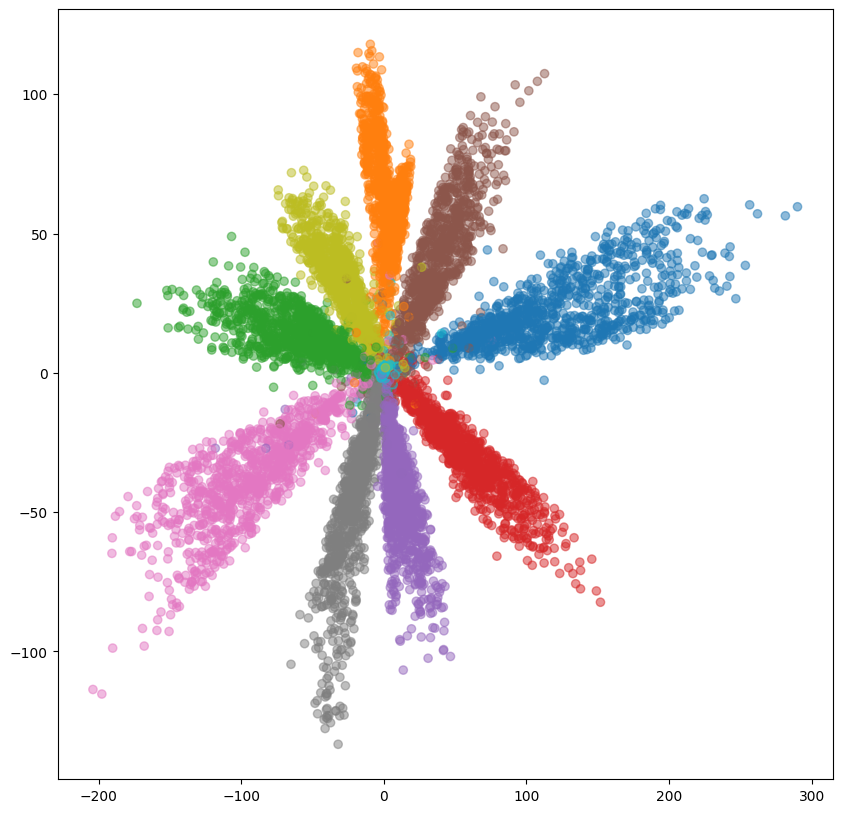

In [18]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.5,
            c=np.concatenate(labels),cmap='tab10')

In [19]:
L=15
X,Y=torch.meshgrid(torch.linspace(-100,200,L),torch.linspace(-100,100,L))
zgrid=torch.stack([X.reshape(-1),Y.reshape(-1)],1)
print(zgrid.shape)

torch.Size([225, 2])


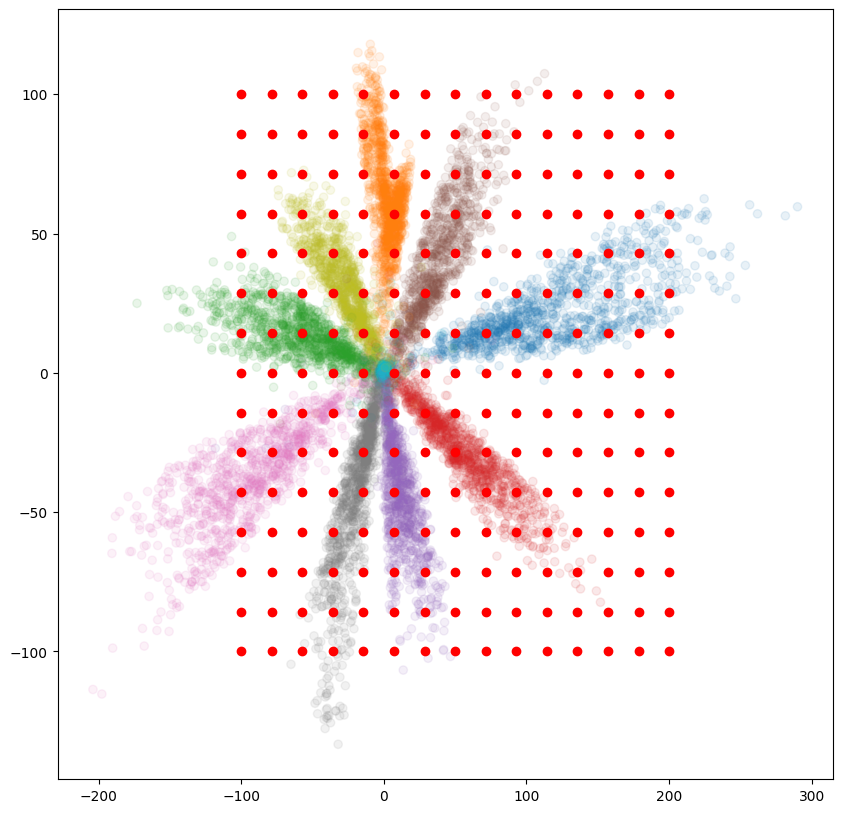

In [20]:
fig=plt.figure(figsize=(10,10))
plt.scatter(np.concatenate(Z)[:,0],np.concatenate(Z)[:,1],alpha=.1,
            c=np.concatenate(labels),cmap='tab10')
plt.scatter(zgrid[:,0],zgrid[:,1],c='r')

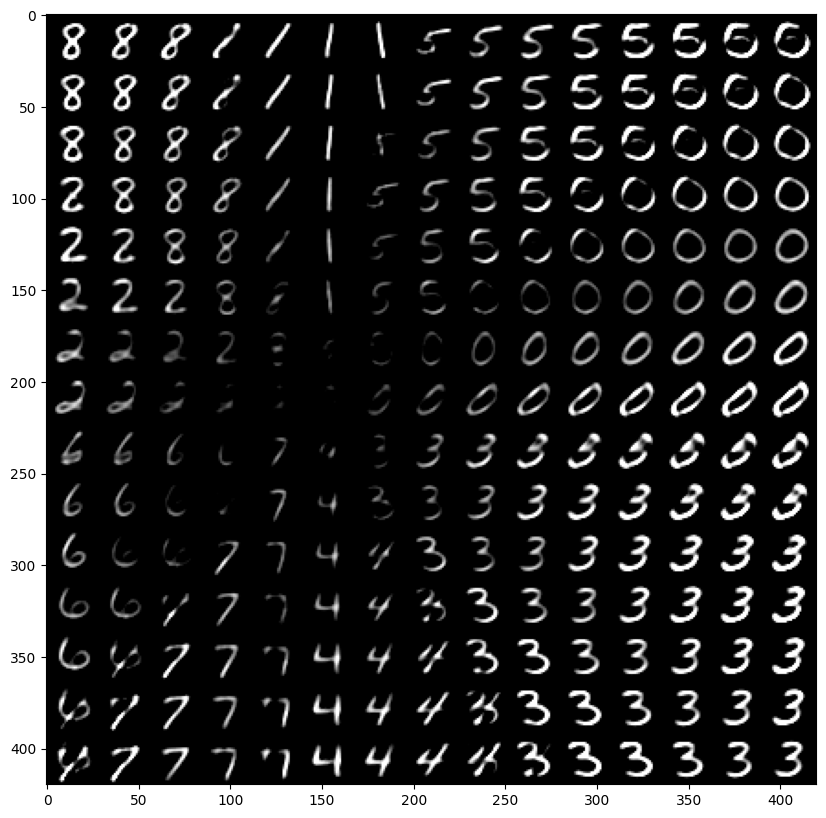

In [21]:
image=model.decode(zgrid.to(device)).reshape(L**2,28,28).data.clip(0,1).cpu().numpy()
img=np.zeros((L*28,L*28))
count=0
for i in np.arange(L-1,-1,-1):
  for j in np.arange(L-1,-1,-1):    
    img[j*28:(j+1)*28,i*28:(i+1)*28]=image[count,:,::-1]
    count+=1
fig=plt.figure(figsize=(10,10))
img=img[:,::-1]
plt.imshow(img,cmap='gray')

Original images


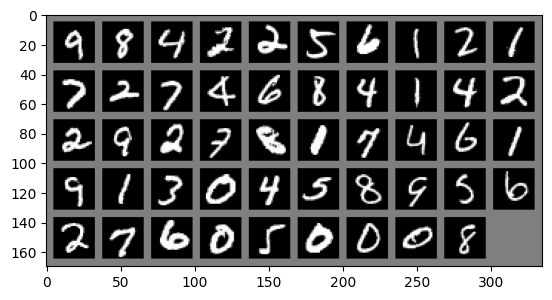

Autoencoder reconstruction:
torch.Size([128, 1, 28, 28])


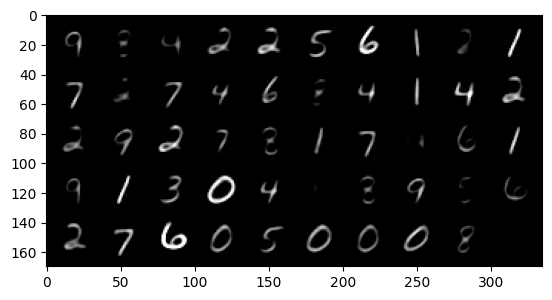

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

autoencoder.eval()

# Note that when we preprocess the data by converting them to 
# the range of [0, 1] and then normalize and center them around 0. 
# After normalization, x was in the range of [-1, 1]. 
# to_img function can convert the x back to its original range of [0, 1].
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy() # convert torch.tensor to numpy.array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# This function takes an image to reconstruct as an input
# and the name of the model with which the reconstructions
# are performed
def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images.reshape(images.shape[0],-1))[0]
        images = images.reshape(images.shape[0],1,28,28).cpu()
        images = images.clamp(0,1)
        print(images.shape)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))


# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, model)